## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly.**

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
# Automatic data downloader to ensure reproducibility
import requests
from zipfile import ZipFile
import shutil
import os

url = 'https://video.udacity-data.com/topher/2017/December/5a32c9a0_analyzeabtestresults-2/analyzeabtestresults-2.zip'
extract_folder = os.getcwd()
download_dest = extract_folder + '/AnalyzeABTestResults 2'

r = requests.get(url)

with open('analyzeabtestresults-2.zip', 'wb') as file:
    file.write(r.content)


with ZipFile('analyzeabtestresults-2.zip') as myzip:
    for member in myzip.namelist():
        filename = os.path.basename(member)
        if not filename:
            continue
        
        if filename in ['ab_data.csv', 'countries.csv']:
            source = myzip.open(member)
            target = open(os.path.join(extract_folder, filename), 'wb')
            with source, target:
                shutil.copyfileobj(source, target)

os.remove('analyzeabtestresults-2.zip')


In [3]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [4]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [5]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [6]:
df['user_id'].nunique()

290584

d. The proportion of users converted.

In [7]:
df['converted'].mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [8]:
# Wrong landing
treatment_old = df[(df['group'] == 'treatment') & (df['landing_page'] == 'old_page')]
control_new = df[(df['group'] == 'control') & (df['landing_page'] == 'new_page')]

# Append wrong landing dataframes
dont_match = treatment_old.append(control_new)

# Retrieve number of observations
dont_match.shape[0]

3893

f. Do any of the rows have missing values?

In [9]:
df.info() #No missing values are showing.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
df2 = pd.concat([df.query('group == "control" & landing_page == "old_page"'), df.query('group == "treatment" & landing_page == "new_page"')], axis=0)
df2 = df2.sort_index()
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2['user_id'].duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2 = df2.drop(2893, axis=0)

`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
df2['converted'].mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control_converted = df2[df2["group"] == "control"]['converted'].mean()
control_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment_converted = df2[df2["group"] == "treatment"]['converted'].mean()
treatment_converted


0.11880806551510564

d. What is the probability that an individual received the new page?

In [19]:
df2[df2["landing_page"] == "new_page"].shape[0] / df2.shape[0]

0.5000619442226688

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**From the data we have, there is not enough evidence to conclude that the new treatment page leads to more conversions. In fact, the conversions from the new page were lower (0.1188) than the old page (0.1204)**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} <= 0$$

$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [21]:
p_new = df2["converted"].mean()
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = p_new
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
n_new = df2[df2["group"] == "treatment"].shape[0]
n_new 

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old = df2[df2["group"] == "control"].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted = np.random.choice([0,1], n_new, p=(1-p_new, p_new))
new_page_converted

array([0, 0, 0, ..., 0, 1, 0])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted = np.random.choice([0,1], n_old, p=(1-p_old, p_old))
old_page_converted

array([1, 0, 0, ..., 1, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

0.0006380678344019425

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
new_converted_simulation = np.random.binomial(n_new, p_new, 10000)/n_new
old_converted_simulation = np.random.binomial(n_old, p_old, 10000)/n_old
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

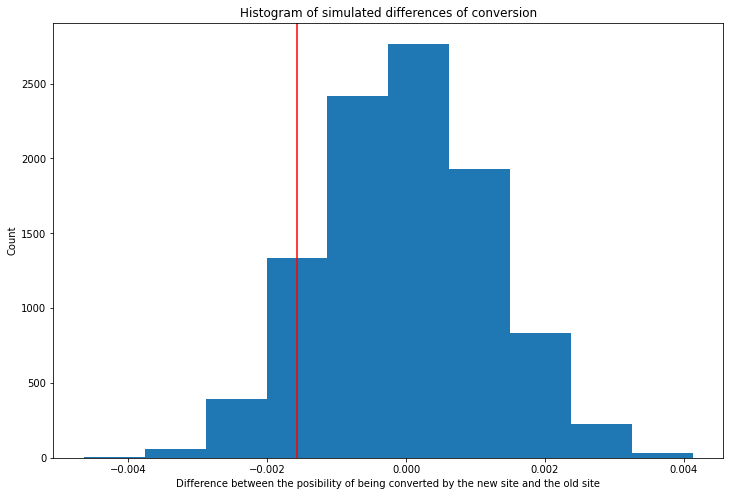

In [29]:
obs_diff = treatment_converted - control_converted

fig, ax = plt.subplots(figsize=(12,8))

ax.hist(p_diffs)
ax.axvline(obs_diff, color="red")

ax.set_xlabel('Difference between the posibility of being converted by the new site and the old site')
ax.set_ylabel('Count')
ax.set_title('Histogram of simulated differences of conversion')

plt.show()

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
(p_diffs > obs_diff).mean()

0.9022

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**I have calculated the p-value. The p-value shows the probability of observing the statistic of our sample if the null hypothesis is true. The p-value has to be less than the type 1 error margin in order to reject the null. In this case, the p-value is 0.9085, which is more than error 1 margin (0.05). This means that we do not have enough evidence to reject the null.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [32]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').shape[0]
n_old = df2[df2["landing_page"] == "old_page"].shape[0]
n_new = df2[df2["landing_page"] == "new_page"].shape[0]

In [33]:
n_new

145310

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:
from statsmodels.stats.proportion import proportions_ztest

counts = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])

stat, pval = proportions_ztest(counts, nobs, alternative='smaller')
stat, pval

(1.3109241984234394, 0.9050583127590245)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The p-value is higher than the error 1 margin rate (0.90 > 0.05). We do not have enough arguments to reject the null. Both methods agree in not having enough evidence to reject the null..**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since all of our values will be between 0 and 1, the best type of regression we can do is a logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
df2["intercept"] = 1
df2[["ab_page"]] = pd.get_dummies(df2["group"], drop_first=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [36]:
lm = sm.Logit(df2["converted"], df2[["intercept", "ab_page"]])
results = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-11-26 11:55 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**The p-value associated with ab_page is 0.1899. It differs because our hypotheses are different. The hypothesis linked to this model are:**

$$H_0: p_{new} = p_{old}$$


$$H_1: p_{new} \neq p_{old}$$


**In the last model, our hypothesis were:**

$$H_0: p_{new} - p_{old} <= 0$$


$$H_1: p_{new} - p_{old} > 0$$

**As we can see, we have performed a one-tailed test in Part 2 and a two-tailed one in Part 3.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Adding more factors to the regression model may predict the outcome better. However, we may incurr in multicolinearity. This means that the factors we are including in our model are correlated. To solve this, we would have to run a VIF test and check that the values were below 10.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [41]:
df3 = pd.read_csv("countries.csv")
df3.head().to_markdown() #Load the countries csv and retrive the first rows to know more about the dataset

'|    |   user_id | country   |\n|---:|----------:|:----------|\n|  0 |    834778 | UK        |\n|  1 |    928468 | US        |\n|  2 |    822059 | UK        |\n|  3 |    711597 | UK        |\n|  4 |    710616 | UK        |'

In [43]:
df4 = df2.join(df3.set_index("user_id"), on="user_id") #Perform the merge between countries dataset and ours taking user id as the index.
df4 = df4.join(pd.get_dummies(df4["country"])) #Retrieve dummy variables for the countries
df4.head().to_markdown()

'|    |   user_id | timestamp                  | group     | landing_page   |   converted |   intercept |   ab_page | country   |   CA |   UK |   US |\n|---:|----------:|:---------------------------|:----------|:---------------|------------:|------------:|----------:|:----------|-----:|-----:|-----:|\n|  0 |    851104 | 2017-01-21 22:11:48.556739 | control   | old_page       |           0 |           1 |         0 | US        |    0 |    0 |    1 |\n|  1 |    804228 | 2017-01-12 08:01:45.159739 | control   | old_page       |           0 |           1 |         0 | US        |    0 |    0 |    1 |\n|  2 |    661590 | 2017-01-11 16:55:06.154213 | treatment | new_page       |           0 |           1 |         1 | US        |    0 |    0 |    1 |\n|  3 |    853541 | 2017-01-08 18:28:03.143765 | treatment | new_page       |           0 |           1 |         1 | US        |    0 |    0 |    1 |\n|  4 |    864975 | 2017-01-21 01:52:26.210827 | control   | old_page       |           1 |   

In [44]:
lm = sm.Logit(df4["converted"], df4[["intercept", "ab_page", "CA", "UK"]]) #Logistics regresion and parameters
results = lm.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-11-26 12:11 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912

In [ ]:
np.exp(0.0099), 1/np.exp(0.0408) #Conversion to read the values correctly.

(1.0099491671175422, 0.9600211149716509)

**The values above show the difference between people coming from different countries. Taking United States as the base to estimate our model, we could say that users from the UK would have a 1.01 times more likely  of being converted than people from the United States. On the other hand, users from Canada would be 0.96 times less likely of being converted than users from the United States.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [47]:
df4["UK_ab_page"] = df4["ab_page"] * df4["UK"]
df4["CA_ab_page"] = df4["ab_page"] * df4["CA"]
df4.head() #Performed the interaction between the landing page and the country.

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,UK_ab_page,CA_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0


In [48]:
lm = sm.Logit(df4["converted"], df4[["intercept", "ab_page", "CA", "UK", "CA_ab_page", "UK_ab_page"]]) #Logistics regresion and parameters
results = lm.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-11-26 13:35 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323

In [ ]:
np.exp(0.0314) , np.exp(-0.0469), np.exp(-0.0057)

(1.0318981806179213, 0.9541828111007262, 0.9943162141784332)

**After performing the interaction to cross the variables, we would be able to know if the new page is working in different countries. In this case, taking US as the base, the UK users will be 1.032 times more likely of being converted when landing in the new page. On the other hand, CA users will be 0.954 times less likely of being converted when landing in the new page.**

**The most interesting factor here is that, holding everything constant, UK users would be a little less likely (0.994) than US users of being converted when considering both landing pages. However, when UK users landed in the new page, the likelihood of them being converted increases in 1.03 times than US users landing in the new page.**

**To conclude, we could say that country has an impact on conversions. It is very litle, but when the amount of users is really high, being 1.03 times more likely to convert someone can have an impact. We could say the same with the landing page. For some countries (like the UK) seems that the new website is working better than the old one. For others, like CA, the old one may work better than the new one.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

4294967295